In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split, KFold

In [97]:
ptb_data = pd.read_csv(r'C:\Users\jeffr\Downloads\ptb_data.csv')

In [98]:
Q1 = ptb_data['DurationSecs'].quantile(0.25)
Q3 = ptb_data['DurationSecs'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
ptb_data = ptb_data[(ptb_data['DurationSecs'] >= lower_bound) & (ptb_data['DurationSecs'] <= upper_bound)]

In [99]:
#df_encoded = ptb_data.drop(columns = ['PTB Defence', 'Anonymize 1PlayerId', 'EventName', 'Club Id', 'Opposition Id', 'PTB Contest',
#                                        'PTB Ultimate Outcome', 'Away Score', 'Half', 'Home Score', 'MatchId','OppPossessionSecs',
#                                     'OppScore','Player Id', 'SeqNumber', 'Set', 'TotalPossessionSecs', 'Tackle', 'ElapsedTime',
#                                      'ZonePhysical','OfficialId','Set Type','RoundId','RunOn','IsHome','WeatherConditionName','Total Involved Tacklers'])

df_encoded = ptb_data.drop(columns = ['PTB Defence', 'Anonymize 1PlayerId', 'EventName','PTB Tackle Result',
                                         'Away Score',  'Home Score', 'MatchId', 'OppPossessionSecs', 'PTB Ultimate Outcome',
                                      'OppScore','Player Id', 'SeqNumber', 'Set', 'TotalPossessionSecs', 'Tackle', 'ElapsedTime',
                                      'ZonePhysical','OfficialId','PositionId'])

df_encoded.columns = df_encoded.columns.str.replace('Raw Tackle Number', 'Raw_Tackle_Number')
#df_encoded.columns = df_encoded.columns.str.replace('PTB Tackle Result', 'PTB_Tackle_Result')
df_encoded.columns = df_encoded.columns.str.replace('Club Id', 'Club_Id')
df_encoded.columns = df_encoded.columns.str.replace('Opposition Id', 'Opposition_Id')
#df_encoded.columns = df_encoded.columns.str.replace('PTB Ultimate Outcome', 'PTB_Ultimate_Outcome')
df_encoded.columns = df_encoded.columns.str.replace('PTB Contest', 'PTB_Contest')
df_encoded.columns = df_encoded.columns.str.replace('Set Type', 'Set_Type')
df_encoded.columns = df_encoded.columns.str.replace('Total Involved Tacklers', 'Total_Involved_Tacklers')


df_encoded = pd.get_dummies(df_encoded, columns=['WeatherConditionName','Raw_Tackle_Number','Half','PTB_Contest','Club_Id',
                                                 'Opposition_Id','SeasonId'], drop_first=True)

df_encoded = df_encoded.dropna()

df_encoded[df_encoded.select_dtypes(include=['bool']).columns] = df_encoded.select_dtypes(include=['bool']).astype(int)

df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109805 entries, 0 to 112026
Data columns (total 62 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   DurationSecs                                       109805 non-null  float64
 1   PossessionSecs                                     109805 non-null  float64
 2   Set_Type                                           109805 non-null  int64  
 3   Total_Involved_Tacklers                            109805 non-null  float64
 4   RoundId                                            109805 non-null  int64  
 5   RunOn                                              109805 non-null  int64  
 6   Score                                              109805 non-null  float64
 7   ZonePossession                                     109805 non-null  int64  
 8   GameTime                                           109805 non-null  float64
 9 

In [100]:
Y = df_encoded['DurationSecs']
X = df_encoded.drop(['DurationSecs'],axis = 1)

In [119]:
np.random.seed(37)

In [121]:
import statsmodels.formula.api as smf
nrl_train, nrl_test = train_test_split(df_encoded, test_size = 0.2,random_state=37)
df_encoded.columns = df_encoded.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

formula = 'DurationSecs ~ ' + ' + '.join(df_encoded.columns.difference(['DurationSecs']))
model = smf.ols(formula=formula, data=df_encoded).fit()
predictions = model.predict(nrl_test)
y_test = nrl_test.DurationSecs
y_train = nrl_train.DurationSecs
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           DurationSecs   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     508.3
Date:                Tue, 19 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:46:23   Log-Likelihood:            -1.3793e+05
No. Observations:              109805   AIC:                         2.760e+05
Df Residuals:                  109743   BIC:                         2.766e+05
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             3.5281      0.023    151.974      0.000       3.483       3.574
Club_Id_1d6cd83892ee4afdcd8ccd94f817b4a6              0.0076      0.016      0.486      0.627      -0.023       0.038
Club_Id_1d6cd83892ee4afdcd8ccd94f81ftnjhl3s          -0.0534      0.026     -2.081      0.037      -0.104      -0.003
Club_Id_367ef61d2bc259e608027a8d349c933e             -0.1597      0.016    -10.198      0.000      -0.190      -0.129
Club_Id_3b26834df063f9d51de216a07ec36929              0.0358      0.015      2.374      0.018       0.006       0.065
Club_Id_58485e3acf60682c8fc37d9d521b3019              0.0521      0.016      3.261      0.001       0.021       0.083
Club_Id_5e03a19f4d014a2220665cfd56522d35             -0.0184      0.016     -1.177      0.239      -0.049       0.012
Club_Id_837e03d56b4dba3b8a4a5425c0420abd             -0.0468      0.015     -3.026      0.002      -0.077      -0.016
Club_Id_980c9c368ae4f1129ea0a6fdd711fa8f             -0.0550      0.016     -3.530      0.000      -0.086      -0.024
Club_Id_a73752d38e4a78e3e14917f5435ffb6d              0.0819      0.015      5.440      0.000       0.052       0.111
Club_Id_b53920c88e4eebf2faa9f4fb43b8944a              0.0641      0.015      4.146      0.000       0.034       0.094
Club_Id_c03196722c1a837b39f79f1714db475d             -0.0873      0.015     -5.682      0.000      -0.117      -0.057
Club_Id_c14e0139ad91a9741a5731a596aa6549              0.0746      0.016      4.748      0.000       0.044       0.105
Club_Id_d3ac47d424b41fd738ec9500dbda2d59             -0.0318      0.015     -2.082      0.037      -0.062      -0.002
Club_Id_dc3c7bd8148814b7c4105841baa68e23             -0.0782      0.015     -5.104      0.000      -0.108      -0.048
Club_Id_f38f7f087f646c38c0207f1b2af32f12             -0.1096      0.015     -7.121      0.000      -0.140      -0.079
Club_Id_fdfcde48e2cbf12cc4710a2644b86d85             -0.0445      0.016     -2.792      0.005      -0.076      -0.013
CurrentMargin                                         0.0008      0.000      1.526      0.127      -0.000       0.002
GameTime                                              0.0011      0.001      1.352      0.176      -0.000       0.003
Half_2                                               -0.0159      0.031     -0.514      0.607      -0.077       0.045
Half_3                                               -0.2956      0.084     -3.528      0.000      -0.460      -0.131
Half_4                                               -0.2972      0.104     -2.858      0.004      -0.501      -0.093
IsHome                                               -0.0268      0.005     -5.085      0.000      -0.037      -0.016
Opposition_Id_1

In [123]:
MSE_lm = np.mean((predictions-y_test)**2)
print('MSE on the test data for linear regression: ',MSE_lm)

MSE on the test data for linear regression:  0.7240801151127735


In [125]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()

X_train = nrl_train.drop('DurationSecs',axis='columns')
scaler.fit(X_train) #fit scaler (estimate mean and std) on training data only!
X_train = scaler.transform(X_train)

# apply the same transformation to test data
X_test = nrl_test.drop('DurationSecs',axis='columns')
X_test = scaler.transform(X_test)

In [127]:
print(X_train[:,1].mean(),X_train[:,1].std()) #check

-1.0677068567043079e-16 1.0


In [129]:
import statsmodels.api as sm

X_train_1 = sm.add_constant(X_train)
X_test_1 = sm.add_constant(X_test)
model_sc = sm.OLS(y_train, X_train_1)
lm_scaled = model_sc.fit()

lm_scaled.summary()

predictions_scaled = lm_scaled.predict(X_test_1)

MSE_lm_scaled = np.mean((predictions_scaled-y_test)**2)
print('MSE on the test data for linear regression: ',MSE_lm_scaled)

MSE on the test data for linear regression:  0.7249085199746118


In [131]:
lm_scaled.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           DurationSecs   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     401.7
Date:                Tue, 19 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:46:48   Log-Likelihood:            -1.1031e+05
No. Observations:               87844   AIC:                         2.207e+05
Df Residuals:                   87782   BIC:                         2.213e+05
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4795      0.003   1213.688      0.000       3.474       3.485
x1             0.0632      0.017      3.621      0.000       0.029       0.097
x2             0.0707      0.005     14.018      0.000       0.061       0.081
x3             0.0546      0.003     18.275      0.000       0.049       0.060
x4            -0.0166      0.003     -5.490      0.000      -0.023      -0.011
x5             0.0376      0.003     12.773      0.000       0.032       0.043
x6             0.0313      0.008      3.933      0.000       0.016       0.047
x7             0.0809      0.005     14.753      0.000       0.070       0.092
x8             0.0059      0.010      0.571      0.568      -0.014       0.026
x9            -0.0131      0.003     -4.433      0.000      -0.019      -0.007
x10            0.0059      0.007      0.839      0.402      -0.008       0.020
x11            0.0126      0.003      4.260      0.000       0.007       0.018
x12            0.0046      0.003      1.572      0.116      -0.001       0.010
x13           -0.0087      0.003     -2.943      0.003      -0.015      -0.003
x14            0.0103      0.003      3.008      0.003       0.004       0.017
x15           -0.1083      0.004    -30.237      0.000      -0.115      -0.101
x16           -0.1375      0.004    -37.269      0.000      -0.145      -0.130
x17           -0.1505      0.004    -38.620      0.000      -0.158      -0.143
x18           -0.1555      0.004    -38.118      0.000      -0.163      -0.148
x19           -0.0407      0.003    -13.181      0.000      -0.047      -0.035
x20           -0.0061      0.003     -2.138      0.033      -0.012      -0.001
x21           -0.0165      0.017     -0.955      0.340      -0.050       0.017
x22           -0.0154      0.004     -3.531      0.000      -0.024      -0.007
x23           -0.0103      0.004     -2.720      0.007      -0.018      -0.003
x24           -0.0034      0.003     -1.189      0.234      -0.009       0.002
x25           -0.2438      0.003    -81.460      0.000      -0.250      -0.238
x26           -0.3440      0.003   -113.834      0.000      -0.350      -0.338
x27           -0.0007      0.004     -0.172      0.864      -0.009       0.007
x28           -0.0049      0.003     -1.488      0.137      -0.011       0.002
x29           -0.0375      0.004     -8.954      0.000      -0.046      -0.029
x30            0.0082      0.004      1.890      0.059      -0.000       0.017
x31            0.0105      0.004      2.614      0.009       0.003       0.018
x32           -0.0061      0.004     -1.489      0.137      -0.014       0.002
x33           -0.0122      0.004     -2.914      0.004      -0.020      -0.004
x34           -0.0130      0.004     -3.132      0.002      -0.021      -0.005
x35            0.0213      0.004      4.920      0.000       0.013       0.030
x3

In [133]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers

In [135]:
num_features=X_train.shape[1]
print(num_features)

61


In [137]:
model = Sequential()


model.add(Input(shape=(num_features,))) # the input layer where the shape of inputs is specified, for now it is just the number of features (more advanced inputs like image data would have more dimension)
model.add(Dense(61, activation='relu')) 
model.add(Dense(61, kernel_regularizer=regularizers.l2(0.001), activation='relu')) 
model.add(Dense(1, activation='linear')) # the output layer has 1 unit, the linear activation is used as this is for regression

In [139]:
model.compile(loss='MSE', optimizer='adam')

In [140]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 61)             │         3,782 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 61)             │         3,782 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            62 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,626 (29.79 KB)

 Trainable params: 7,626 (29.79 KB)

 Non-trainable params: 0 (0.00 B)

In [141]:
modelout = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/100
8785/8785 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.9971 - val_loss: 0.7516
Epoch 2/100
8785/8785 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.7489 - val_loss: 0.7385
Epoch 3/100
8785/8785 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.7224 - val_loss: 0.7242
Epoch 4/100
8785/8785 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.7108 - val_loss: 0.7204
Epoch 5/100
8785/8785 ━━━━━━━━━━━━━━━━━━━━ 8s 923us/step - loss: 0.7027 - val_loss: 0.7126
Epoch 6/100
8785/8785 ━━━━━━━━━━━━━━━━━━━━ 8s 957us/step - loss: 0.6953 - val_loss: 0.7165
Epoch 7/100
8785/8785 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 0.6930 - val_loss: 0.7235
Epoch 8/100
8785/8785 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.6892 - val_loss: 0.7111
Epoch 9/100
8785/8785 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 0.6910 - val_loss: 0.7234
Epoch 10/100
8785/8785 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.6868 - val_loss: 0.7133
Epoch 11/100
8785/8785 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.6839 - val_loss: 0.7101
Epoch 12/

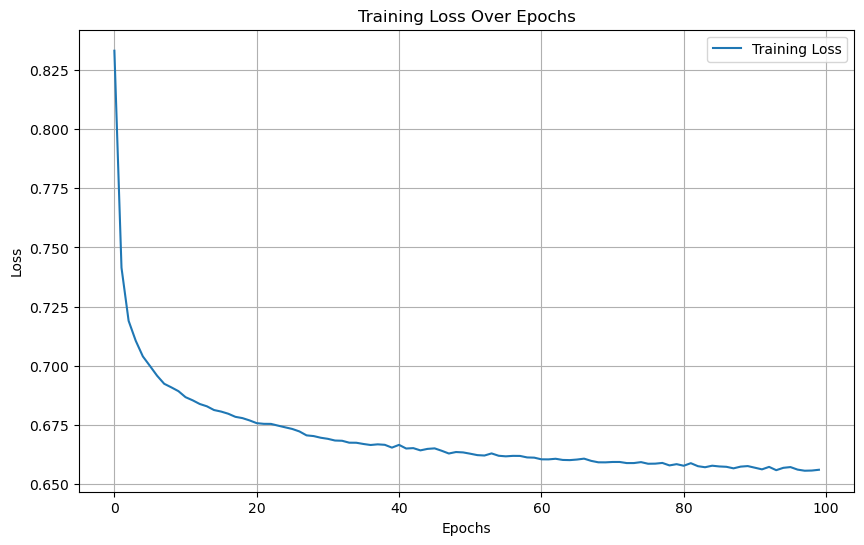

In [142]:
plt.figure(figsize=(10, 6))
plt.plot(modelout.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [143]:
MSE_nn = model.evaluate(X_test, y_test, verbose=0)
print('\nMSE on the test data for neural net: ', MSE_nn)
print('MSE on the test data for linear reg: ', MSE_lm_scaled)


MSE on the test data for neural net:  0.7096569538116455
MSE on the test data for linear reg:  0.7249085199746118


In [144]:
def compute_saliency(model, input_data):
    input_data = tf.convert_to_tensor(input_data)  # Ensure input data is a tensor
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        prediction = model(input_data)
    # Get the gradients of the output with respect to the input
    saliency = tape.gradient(prediction, input_data)
    return saliency.numpy()

saliency_map = compute_saliency(model, X_train)

# Convert list to array and compute mean across samples
all_saliencies = np.array(saliency_map).squeeze()  # Remove extra dimensions if necessary
average_saliency = np.mean(all_saliencies, axis=0)

#compare with regression coefficients and add names of the features
feature_importance = pd.DataFrame({
    "Feature": nrl_train.columns[:-1],
    "Average Saliency": average_saliency,
    "Regression Coefficient (scaled)": lm_scaled.params[1:],
    "Regression p-values": lm_scaled.pvalues[1:].round(5)
})
feature_importance = feature_importance[feature_importance["Feature"] != "DurationSecs"]

feature_importance

,Feature,Average Saliency,Regression Coefficient (scaled),Regression p-values
x2,PossessionSecs,0.035923,0.070733,0.00000
x3,Set_Type,0.086189,0.054588,0.00000
x4,Total_Involved_Tacklers,-0.011765,-0.016583,0.00000
x5,RoundId,0.096820,0.037637,0.00000
x6,RunOn,0.007176,0.031298,0.00008
x7,Score,0.086296,0.080880,0.00000
x8,ZonePossession,0.022730,0.005864,0.56829
x9,GameTime,-0.002788,-0.013069,0.00001
x10,IsHome,0.026532,0.005901,0.40161
x11,CurrentMargin,-0.111041,0.012614,0.00002


In [145]:
top_features = feature_importance.sort_values(by="Average Saliency", ascending=False).head(5)

# Display top 5 most important features
top_features

,Feature,Average Saliency,Regression Coefficient (scaled),Regression p-values
x5,RoundId,0.096820,0.037637,0.0
x7,Score,0.086296,0.080880,0.0
x3,Set_Type,0.086189,0.054588,0.0
x60,SeasonId_2021,0.072612,0.110491,0.0
x61,SeasonId_2022,0.062870,0.084829,0.0


In [146]:
feature_importance.to_csv('feature_importance_table3.csv', index=False)

In [147]:
# The following code was used with inspiration from https://kitchell.github.io/DeepLearningTutorial/8evaluatingnns.html
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare the data
X = df_encoded.drop('DurationSecs', axis=1).values
y = df_encoded['DurationSecs'].values

# Set up K-Fold Cross-Validation with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# List to store MSE for each fold
mse_scores = []

# Iterate through each fold
for fold, (train_index, val_index) in enumerate(kf.split(X), start=1):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_val_fold = scaler.transform(X_val_fold)

    # Define the model
    model = Sequential([
        Input(shape=(X_train_fold.shape[1],)),
        Dense(68, activation='relu'),
        Dense(68, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
        Dense(1, activation='linear')
    ])

    # Compile the model
    model.compile(loss='MSE', optimizer='adam')

    # Train the model
    model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=10, verbose=0)

    # Evaluate the model
    y_val_pred = model.predict(X_val_fold).flatten()
    mse = mean_squared_error(y_val_fold, y_val_pred)
    mse_scores.append(mse)
    print(f"Fold {fold} MSE: {mse}")

# Calculate and print the average MSE across all folds
average_mse = np.mean(mse_scores)
print("\nCross-Validation MSE Scores:", mse_scores)
print("Average MSE:", average_mse)

687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fold 1 MSE: 0.7107596172390224
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fold 2 MSE: 0.7033375284070292
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fold 3 MSE: 0.7067536769833713
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fold 4 MSE: 0.7062760766539103
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Fold 5 MSE: 0.701644751300968

Cross-Validation MSE Scores: [0.7107596172390224, 0.7033375284070292, 0.7067536769833713, 0.7062760766539103, 0.701644751300968]
Average MSE: 0.7057543301168603
